# 1. 导入库

In [1]:
import time
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') # 展示高清图，在 Jupyter Notebook 中设置 matplotlib 图形的输出格式为 SVG 格式

import torch
import torch.nn as nn
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as TTS
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

E:\Anaconda\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. 读取数据+预处理+PCA降维+划分数据集

#### （1）读取数据+预处理+PCA降维

In [2]:
# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data = pd.read_csv(r"F:\Code_Data\2_Rocks_Spectrum_Reflectance_essay_30_origin_modify_2.csv",encoding='utf-8') #encoding='GBK',防止中文乱码

In [4]:
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]
X_SG = savgol_filter(X, 5, 2)
X_SG_std = StandardScaler().fit_transform(X_SG)
Label = LabelEncoder().fit_transform(y)
data.iloc[:,1:-1] = X_SG_std
data.iloc[:, -1] = Label
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

In [5]:
X.shape, y.shape

((11828, 2151), (11828,))

In [6]:
X_dr = PCA(26).fit_transform(X)

In [7]:
# 转换为 torch 中的张量格式
X_tensor = torch.tensor(X_dr, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [8]:
# 将数据移动到GPU
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

In [9]:
X_tensor.shape, y_tensor.shape

(torch.Size([11828, 26]), torch.Size([11828]))

#### （2）使用和RF和Xgvoost相同的划分数据集的方法

In [10]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X_dr,y,test_size=0.3,random_state=0)

In [11]:
# 转换为 torch 中的张量格式
X_train_tensor = torch.tensor(Xtrain, dtype=torch.float32)
X_test_tensor = torch.tensor(Xtest, dtype=torch.float32)
y_train_tensor = torch.tensor(Ytrain, dtype=torch.long)
y_test_array = Ytest.values
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long)

In [12]:
# 将数据移动到GPU
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [13]:
# 创建训练集和测试集的 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建 DataLoader 对象
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_size = len(train_dataset)
test_size = len(test_dataset)

In [14]:
train_size, test_size

(8279, 3549)

#### （3）常规划分训练集和测试集

In [115]:
# 创建 TensorDataset 对象
Data = TensorDataset(X_tensor,y_tensor)

In [ ]:
# 创建 DataLoader 对象，用于批量加载数据
dataloader = DataLoader(Data, batch_size=128,shuffle=True)

In [66]:
# 划分训练集和测试集
train_ratio = 0.7
dataset_size = len(Data)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# 使用 random_split 方法将数据集分成训练集和测试集
train_dataset, test_dataset = random_split(Data, [train_size, test_size])

# 创建训练集 DataLoader 对象
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True) # shuffle 用于在每一个 epoch 内先洗牌再分批。

# 创建测试集 DataLoader 对象
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [67]:
train_size, test_size

(8083, 3465)

# 3. 搭建神经网络

#### （1）调整隐藏层尺寸，dropout概率

In [15]:
# 搭建网络
class DNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layer_sizes, dropout_prob):
        ''' 搭建神经网络各层 '''
        super(DNN, self).__init__()

        self.hidden_layer_sizes = hidden_layer_sizes  # 调整隐藏层尺寸
        self.dropout_prob = dropout_prob  # 调整 dropout 概率

        layers = []
        prev_layer_size = input_size

        for layer_size in self.hidden_layer_sizes:
            layers.append(nn.Linear(prev_layer_size, layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout_prob))
            prev_layer_size = layer_size

        layers.append(nn.Linear(prev_layer_size, num_classes))

        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [16]:
# 超参数
num_classes = 33
input_size = X_tensor.shape[1]
hidden_layer_sizes = [32, 64, 128]  # 你可以根据需要调整隐藏层尺寸
dropout_prob = 0.3  # 你可以根据需要调整 dropout 概率

In [17]:
# 创建模型实例
model = DNN(input_size, num_classes, hidden_layer_sizes, dropout_prob)
model.to(device)
print(model)

DNN(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=33, bias=True)
  )
)


#### （2）简单的搭建

In [55]:
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential(nn.Linear(30, 32), nn.ReLU() # 第 1 层：全连接层
                                 ,nn.Linear(32, 8), nn.ReLU() # 第 2 层：全连接层
                                 ,nn.Linear(8, 4), nn.ReLU() # 第 3 层：全连接层
                                 ,nn.Linear(4, num_classes)# 第 4 层：全连接层，输出节点数设置为类别的数量
                                )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [56]:
num_classes = len(np.unique(y))  # 类别的数量
input_size = X_tensor.shape[1]  # 输入特征的维度，即特征数量
model = DNN(input_size, num_classes)
#model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=33, bias=True)
  )
)

# 4. 训练网络

In [254]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量

In [255]:
# 优化算法的选择
learning_rate = 0.001 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [256]:
# 训练网络
epochs = 200
accuracies = [] # 记录准确率变化的列表
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    total_correct = 0
    total_samples = 0
    
    for (x, y) in train_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)
        total_correct += torch.sum(Pred_classes == y)
        total_samples += y.size(0)
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
        
    accuracy = total_correct / total_samples
    accuracies.append(accuracy.item())

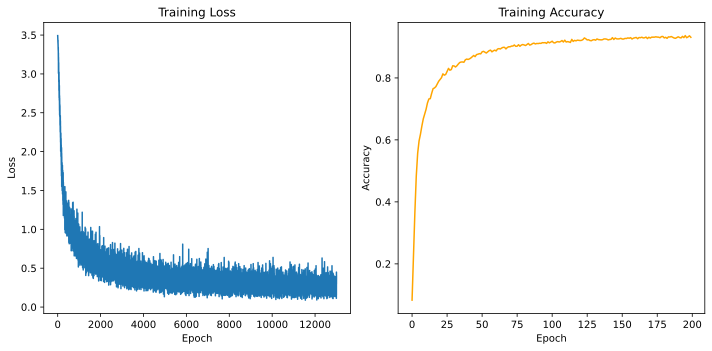

In [257]:
# 绘制损失曲线和准确率变化曲线
plt.figure(figsize=(10, 5))  # 设置整体图的大小

# 创建第一个子图（左侧），绘制训练损失曲线
plt.subplot(1, 2, 1)  # 参数依次为：行数，列数，子图编号
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# 创建第二个子图（右侧），绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies)), accuracies, color='orange')  # 使用橙色表示准确率
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout() # 调整子图的布局，防止重叠

# 5. 测试网络

In [258]:
# 测试网络
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 93.15299987792969 %


In [20]:
# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 6. Optuna——随机网格搜索，调参

#### （1）构建目标函数及定义参数空间¶

In [18]:
def optuna_objective(trial):
    
    # 定义超参数空间
    #hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(len(hidden_layer_sizes))]
    hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(trial.suggest_int("num_hidden_layers", 3, 5))]
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.5)
    
    # 根据超参数定义 DNN 模型
    model = DNN(input_size, num_classes, hidden_layer_sizes, dropout_prob)
    model.to(device)
    
    # 定义优化器和损失函数
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    EPOCHS = 200
    
    # 训练模型
    model.train()
    for epoch in range(EPOCHS):
        for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model(x) # 一次前向传播（小批量）
            loss = loss_fn(output, y) # 计算损失函数
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
    
    # 验证模型
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for (x, y) in test_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            Pred = model(x) # 一次前向传播（小批量）
            _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
            correct += torch.sum(Pred_classes == y)  # 计算正确的个数
            all_preds.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
            all_labels.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
            total += y.size(0)
    accuracy = correct/total
    
    # 报告准确率给 Optuna
    trial.report(accuracy, epoch)
    
    return accuracy

#### （2）定义优化目标函数的具体流程

In [19]:
# 定义超参数优化器函数
def optimizer_optuna(n_trials, algo):

    #定义使用随机网格搜索
    sampler = optuna.samplers.RandomSampler(seed=0)

    #实际优化过程，首先实例化优化器
    study = optuna.create_study(sampler = sampler #要使用的具体算法
                                ,direction="maximize" #优化的方向，可以填写minimize或maximize
                               )
    #开始优化，n_trials为允许的最大迭代次数
    #由于参数空间已经在目标函数中定义好，因此不需要输入参数空间
    study.optimize(optuna_objective #目标函数
                   ,n_trials=n_trials #最大迭代次数（包括最初的观测值的）
                   ,show_progress_bar=True #要不要展示进度条呀？
                  )

    #可直接从优化好的对象study中调用优化的结果
    #打印最佳参数与最佳损失值
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")

    return study.best_trial.params, study.best_trial.values

#### （3）执行优化操作

In [20]:
def optimized_optuna_search_and_report(n_trials, algo):
    start_time = time.time()

    # 进行随机网格搜索优化
    best_params, best_score = optimizer_optuna(n_trials, algo)

    # 打印最佳参数和分数
    print("\n","\n","best params: ", best_params,
          "\n","\n","best score: ", best_score,
          "\n")

    end_time = time.time()
    time_random = (end_time - start_time) / 60  # 转换为分钟
    print(f"Optimization completed in {time_random} minutes.")

    return best_params, best_score, time_random

# 执行优化
best_params, best_score, time_random = optimized_optuna_search_and_report(30, "Random")

[I 2023-08-30 22:23:53,072] A new study created in memory with name: no-name-8b306caa-7bd1-4a57-970d-52bdff5509e4
Best trial: 0. Best value: 0.845872:   3%|█▌                                            | 1/30 [01:22<39:57, 82.68s/it]

[I 2023-08-30 22:25:16,003] Trial 0 finished with value: 0.8458721041679382 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 188, 'hidden_layer_size_1': 161, 'hidden_layer_size_2': 147, 'hidden_layer_size_3': 118, 'learning_rate': 0.0038333321561566623, 'dropout_prob': 0.275034884505077, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8458721041679382.


Best trial: 0. Best value: 0.845872:   7%|███                                           | 2/30 [02:22<32:26, 69.52s/it]

[I 2023-08-30 22:26:16,307] Trial 1 finished with value: 0.30008453130722046 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 143, 'hidden_layer_size_1': 152, 'hidden_layer_size_2': 239, 'hidden_layer_size_3': 33, 'hidden_layer_size_4': 36, 'learning_rate': 1.2046852412030316e-05, 'dropout_prob': 0.4330479382191752, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.8458721041679382.


Best trial: 0. Best value: 0.845872:  10%|████▌                                         | 3/30 [03:21<29:04, 64.60s/it]

[I 2023-08-30 22:27:15,062] Trial 2 finished with value: 0.03240349516272545 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 127, 'hidden_layer_size_1': 204, 'hidden_layer_size_2': 44, 'hidden_layer_size_3': 170, 'hidden_layer_size_4': 50, 'learning_rate': 0.06007249475906202, 'dropout_prob': 0.3087393287000287, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.8458721041679382.


Best trial: 3. Best value: 0.888701:  13%|██████▏                                       | 4/30 [04:20<27:00, 62.34s/it]

[I 2023-08-30 22:28:13,920] Trial 3 finished with value: 0.8887010812759399 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 152, 'hidden_layer_size_1': 20, 'hidden_layer_size_2': 164, 'hidden_layer_size_3': 163, 'learning_rate': 0.002935864364395358, 'dropout_prob': 0.4774992314058497, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.8887010812759399.


Best trial: 4. Best value: 0.960271:  17%|███████▋                                      | 5/30 [05:14<24:39, 59.18s/it]

[I 2023-08-30 22:29:07,495] Trial 4 finished with value: 0.9602705240249634 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 30, 'hidden_layer_size_1': 176, 'hidden_layer_size_2': 177, 'hidden_layer_size_3': 66, 'hidden_layer_size_4': 47, 'learning_rate': 0.0001826894228153232, 'dropout_prob': 0.24548430837704904, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  20%|█████████▏                                    | 6/30 [06:05<22:32, 56.37s/it]

[I 2023-08-30 22:29:58,418] Trial 5 finished with value: 0.956889271736145 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 66, 'hidden_layer_size_1': 54, 'hidden_layer_size_2': 173, 'learning_rate': 0.00010307810128023635, 'dropout_prob': 0.2865243091425225, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  23%|██████████▋                                   | 7/30 [06:46<19:44, 51.52s/it]

[I 2023-08-30 22:30:39,945] Trial 6 finished with value: 0.1022823378443718 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 49, 'hidden_layer_size_1': 63, 'hidden_layer_size_2': 104, 'hidden_layer_size_3': 213, 'learning_rate': 2.445710810231886e-05, 'dropout_prob': 0.4351779629995216, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  27%|████████████▎                                 | 8/30 [07:30<17:57, 48.97s/it]

[I 2023-08-30 22:31:23,464] Trial 7 finished with value: 0.10200056433677673 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 161, 'hidden_layer_size_1': 194, 'hidden_layer_size_2': 25, 'hidden_layer_size_3': 84, 'hidden_layer_size_4': 44, 'learning_rate': 0.0001529539827781372, 'dropout_prob': 0.14749108758169763, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  30%|█████████████▊                                | 9/30 [08:23<17:34, 50.20s/it]

[I 2023-08-30 22:32:16,380] Trial 8 finished with value: 0.03183995559811592 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 152, 'hidden_layer_size_1': 79, 'hidden_layer_size_2': 142, 'hidden_layer_size_3': 38, 'hidden_layer_size_4': 154, 'learning_rate': 0.05214165242447226, 'dropout_prob': 0.22742758098052948, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  33%|███████████████                              | 10/30 [09:04<15:51, 47.58s/it]

[I 2023-08-30 22:32:58,082] Trial 9 finished with value: 0.8095238208770752 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 60, 'hidden_layer_size_1': 157, 'hidden_layer_size_2': 20, 'learning_rate': 0.02068998219217129, 'dropout_prob': 0.10187819047701883, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  37%|████████████████▌                            | 11/30 [10:10<16:50, 53.19s/it]

[I 2023-08-30 22:34:03,997] Trial 10 finished with value: 0.035784728825092316 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 75, 'hidden_layer_size_1': 154, 'hidden_layer_size_2': 158, 'hidden_layer_size_3': 153, 'hidden_layer_size_4': 69, 'learning_rate': 0.06471367240175245, 'dropout_prob': 0.27885015144705094, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  40%|██████████████████                           | 12/30 [11:16<17:05, 56.97s/it]

[I 2023-08-30 22:35:09,614] Trial 11 finished with value: 0.8306565284729004 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 111, 'hidden_layer_size_1': 228, 'hidden_layer_size_2': 156, 'hidden_layer_size_3': 228, 'hidden_layer_size_4': 182, 'learning_rate': 0.007961907345193564, 'dropout_prob': 0.30052975277068095, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  43%|███████████████████▌                         | 13/30 [12:03<15:17, 53.98s/it]

[I 2023-08-30 22:35:56,702] Trial 12 finished with value: 0.9554804563522339 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 20, 'hidden_layer_size_1': 88, 'hidden_layer_size_2': 175, 'hidden_layer_size_3': 85, 'learning_rate': 0.0029652527407725646, 'dropout_prob': 0.27150748037830646, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  47%|█████████████████████                        | 14/30 [12:43<13:18, 49.90s/it]

[I 2023-08-30 22:36:37,166] Trial 13 finished with value: 0.954353392124176 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 154, 'hidden_layer_size_1': 173, 'hidden_layer_size_2': 173, 'hidden_layer_size_3': 119, 'learning_rate': 0.03856438264681121, 'dropout_prob': 0.24702474801915864, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  50%|██████████████████████▌                      | 15/30 [13:39<12:52, 51.49s/it]

[I 2023-08-30 22:37:32,365] Trial 14 finished with value: 0.03240349516272545 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 40, 'hidden_layer_size_1': 237, 'hidden_layer_size_2': 188, 'hidden_layer_size_3': 256, 'hidden_layer_size_4': 52, 'learning_rate': 0.029682756505313473, 'dropout_prob': 0.16499717387054993, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  53%|████████████████████████                     | 16/30 [14:44<13:00, 55.71s/it]

[I 2023-08-30 22:38:37,883] Trial 15 finished with value: 0.44773176312446594 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 153, 'hidden_layer_size_1': 114, 'hidden_layer_size_2': 32, 'hidden_layer_size_3': 184, 'hidden_layer_size_4': 125, 'learning_rate': 0.007730763684620935, 'dropout_prob': 0.4465529303714517, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  57%|█████████████████████████▌                   | 17/30 [15:41<12:07, 55.96s/it]

[I 2023-08-30 22:39:34,423] Trial 16 finished with value: 0.9557622075080872 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 191, 'hidden_layer_size_1': 57, 'hidden_layer_size_2': 141, 'hidden_layer_size_3': 29, 'learning_rate': 6.30937149822963e-05, 'dropout_prob': 0.1074087177842456, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  60%|███████████████████████████                  | 18/30 [16:45<11:40, 58.37s/it]

[I 2023-08-30 22:40:38,396] Trial 17 finished with value: 0.6956889629364014 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 185, 'hidden_layer_size_1': 23, 'hidden_layer_size_2': 55, 'hidden_layer_size_3': 165, 'hidden_layer_size_4': 155, 'learning_rate': 8.94481340878346e-05, 'dropout_prob': 0.4736855991699175, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  63%|████████████████████████████▌                | 19/30 [17:28<09:52, 53.88s/it]

[I 2023-08-30 22:41:21,829] Trial 18 finished with value: 0.8734855055809021 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 91, 'hidden_layer_size_1': 111, 'hidden_layer_size_2': 66, 'hidden_layer_size_3': 60, 'hidden_layer_size_4': 243, 'learning_rate': 0.009082453440211006, 'dropout_prob': 0.2961835234470268, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  67%|██████████████████████████████               | 20/30 [18:24<09:06, 54.61s/it]

[I 2023-08-30 22:42:18,147] Trial 19 finished with value: 0.831501841545105 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 91, 'hidden_layer_size_1': 183, 'hidden_layer_size_2': 107, 'hidden_layer_size_3': 59, 'learning_rate': 1.2552057312500426e-05, 'dropout_prob': 0.12689985258529946, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  70%|███████████████████████████████▍             | 21/30 [19:18<08:08, 54.23s/it]

[I 2023-08-30 22:43:11,495] Trial 20 finished with value: 0.45787546038627625 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 254, 'hidden_layer_size_1': 68, 'hidden_layer_size_2': 175, 'hidden_layer_size_3': 79, 'hidden_layer_size_4': 20, 'learning_rate': 0.010802259731953855, 'dropout_prob': 0.22800686032898715, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  73%|█████████████████████████████████            | 22/30 [19:58<06:40, 50.06s/it]

[I 2023-08-30 22:43:51,827] Trial 21 finished with value: 0.9436461329460144 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 226, 'hidden_layer_size_1': 81, 'hidden_layer_size_2': 208, 'hidden_layer_size_3': 60, 'learning_rate': 0.06473909557586699, 'dropout_prob': 0.37499531055512614, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 4. Best value: 0.960271:  77%|██████████████████████████████████▌          | 23/30 [20:35<05:22, 46.02s/it]

[I 2023-08-30 22:44:28,430] Trial 22 finished with value: 0.14313891530036926 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 67, 'hidden_layer_size_1': 140, 'hidden_layer_size_2': 22, 'learning_rate': 6.758966622072009e-05, 'dropout_prob': 0.26987418750060255, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.9602705240249634.


Best trial: 23. Best value: 0.963934:  80%|███████████████████████████████████▏        | 24/30 [21:31<04:55, 49.26s/it]

[I 2023-08-30 22:45:25,238] Trial 23 finished with value: 0.963933527469635 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 224, 'hidden_layer_size_1': 44, 'hidden_layer_size_2': 140, 'hidden_layer_size_3': 47, 'learning_rate': 0.007369511905048896, 'dropout_prob': 0.2584238811229175, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.963933527469635.


Best trial: 23. Best value: 0.963934:  83%|████████████████████████████████████▋       | 25/30 [22:19<04:03, 48.71s/it]

[I 2023-08-30 22:46:12,652] Trial 24 finished with value: 0.03324880450963974 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 101, 'hidden_layer_size_1': 242, 'hidden_layer_size_2': 200, 'hidden_layer_size_3': 196, 'learning_rate': 0.041198268053920954, 'dropout_prob': 0.13336897417680743, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.963933527469635.


Best trial: 23. Best value: 0.963934:  87%|██████████████████████████████████████▏     | 26/30 [23:09<03:16, 49.20s/it]

[I 2023-08-30 22:47:02,995] Trial 25 finished with value: 0.06565229594707489 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 74, 'hidden_layer_size_1': 40, 'hidden_layer_size_2': 19, 'learning_rate': 0.05225372642279875, 'dropout_prob': 0.36796661863636404, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.963933527469635.


Best trial: 23. Best value: 0.963934:  90%|███████████████████████████████████████▌    | 27/30 [23:46<02:16, 45.36s/it]

[I 2023-08-30 22:47:39,413] Trial 26 finished with value: 0.230205699801445 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 133, 'hidden_layer_size_1': 251, 'hidden_layer_size_2': 227, 'learning_rate': 0.0002252349634321645, 'dropout_prob': 0.48462806181659945, 'optimizer': 'SGD'}. Best is trial 23 with value: 0.963933527469635.


Best trial: 23. Best value: 0.963934:  93%|█████████████████████████████████████████   | 28/30 [24:29<01:29, 44.84s/it]

[I 2023-08-30 22:48:23,019] Trial 27 finished with value: 0.049591436982154846 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 167, 'hidden_layer_size_1': 226, 'hidden_layer_size_2': 86, 'hidden_layer_size_3': 220, 'hidden_layer_size_4': 164, 'learning_rate': 1.1296591673520513e-05, 'dropout_prob': 0.23889340717288784, 'optimizer': 'SGD'}. Best is trial 23 with value: 0.963933527469635.


Best trial: 23. Best value: 0.963934:  97%|██████████████████████████████████████████▌ | 29/30 [25:17<00:45, 45.82s/it]

[I 2023-08-30 22:49:11,139] Trial 28 finished with value: 0.9366018772125244 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 170, 'hidden_layer_size_1': 104, 'hidden_layer_size_2': 48, 'hidden_layer_size_3': 214, 'learning_rate': 5.7463443507233836e-05, 'dropout_prob': 0.30452759301858245, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.963933527469635.


Best trial: 29. Best value: 0.964215: 100%|████████████████████████████████████████████| 30/30 [26:10<00:00, 52.35s/it]

[I 2023-08-30 22:50:03,939] Trial 29 finished with value: 0.9642152786254883 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 247, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 96, 'hidden_layer_size_4': 35, 'learning_rate': 0.0004255638073105697, 'dropout_prob': 0.19289365686837712, 'optimizer': 'RMSprop'}. Best is trial 29 with value: 0.9642152786254883.

 
 best params:  {'num_hidden_layers': 5, 'hidden_layer_size_0': 247, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 96, 'hidden_layer_size_4': 35, 'learning_rate': 0.0004255638073105697, 'dropout_prob': 0.19289365686837712, 'optimizer': 'RMSprop'} 
 
 best score:  [0.9642152786254883] 


 
 best params:  {'num_hidden_layers': 5, 'hidden_layer_size_0': 247, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 96, 'hidden_layer_size_4': 35, 'learning_rate': 0.0004255638073105697, 'dropout_prob': 0.19289365686837712, 'optimizer': 

# 7. Optuna——贝叶斯优化，调参

#### （1）构建目标函数及定义参数空间

In [21]:
def optuna_objective(trial):
    
    # 定义超参数空间
    #hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(len(hidden_layer_sizes))]
    hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(trial.suggest_int("num_hidden_layers", 3, 5))]
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.5, step=0.01)
    
    
    # 根据超参数定义 DNN 模型
    model = DNN(input_size, num_classes, hidden_layer_sizes, dropout_prob)
    model.to(device)
    
    # 定义优化器和损失函数
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    EPOCHS = 200
    
    # 训练模型
    model.train()
    for epoch in range(EPOCHS):
        for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model(x) # 一次前向传播（小批量）
            loss = loss_fn(output, y) # 计算损失函数
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
    
    # 验证模型
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for (x, y) in test_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            Pred = model(x) # 一次前向传播（小批量）
            _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
            correct += torch.sum(Pred_classes == y)  # 计算正确的个数
            all_preds.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
            all_labels.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
            total += y.size(0)
    accuracy = correct/total
    
    # 报告准确率给 Optuna
    trial.report(accuracy, epoch)
    
    return accuracy

#### （2）定义优化目标函数的具体流程

In [22]:
# 定义超参数优化器函数
def optimizer_optuna(n_trials, algo):

    #定义使用TPE或者GP
    if algo == "TPE":
        algo = optuna.samplers.TPESampler(n_startup_trials = 15, n_ei_candidates = 12)
    elif algo == "GP":
        from optuna.integration import SkoptSampler
        import skopt
        algo = SkoptSampler(skopt_kwargs={'base_estimator':'GP', #选择高斯过程
                                          'n_initial_points':30, #初始观测点10个
                                          'acq_func':'EI'} #选择的采集函数为EI，期望增量
                           )

    #实际优化过程，首先实例化优化器
    study = optuna.create_study(sampler = algo #要使用的具体算法
                                ,direction="maximize" #优化的方向，可以填写minimize或maximize
                               )
    #开始优化，n_trials为允许的最大迭代次数
    #由于参数空间已经在目标函数中定义好，因此不需要输入参数空间
    study.optimize(optuna_objective #目标函数
                   ,n_trials=n_trials #最大迭代次数（包括最初的观测值的）
                   ,show_progress_bar=True #展示进度条
                  )

    #可直接从优化好的对象study中调用优化的结果
    #打印最佳参数与最佳损失值
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")

    return study.best_trial.params, study.best_trial.values

#### （3）执行优化操作

In [23]:
import time

def optimized_optuna_search_and_report(n_trials, algo):
    start_time = time.time()

    # 定义使用TPE或者GP
    #if algo == "TPE":
    #    algo_sampler = optuna.samplers.TPESampler(n_startup_trials=50, n_ei_candidates=12)
    #elif algo == "GP":
    #    from optuna.integration import SkoptSampler
    #    import skopt
    #    algo_sampler = SkoptSampler(skopt_kwargs={'base_estimator': 'GP',
    #                                              'n_initial_points': 30,
    #                                              'acq_func': 'EI'})

    # 进行超参数优化
    #study = optuna.create_study(sampler=algo_sampler, direction="maximize")
    #study.optimize(optuna_objective, n_trials=n_trials, show_progress_bar=True)
    
    # 进行贝叶斯优化
    best_params, best_score = optimizer_optuna(n_trials, algo)

    # 打印最佳参数和分数
    #best_trial = study.best_trial
    #best_params = best_trial.params
    #best_score = best_trial.value
    print("\n", "\n", "best params: ", best_params,
          "\n", "\n", "best score: ", best_score,
          "\n")

    end_time = time.time()
    time_bayes = (end_time - start_time) / 60  # 转换为分钟
    print(f"Optimization completed in {time_bayes} minutes.")

    return best_params, best_score, time_bayes

# 执行优化
best_params, best_score, time_bayes = optimized_optuna_search_and_report(30, "TPE")

[I 2023-08-30 22:50:04,220] A new study created in memory with name: no-name-4b2d2ac1-65ce-48de-bbcb-b1e2b0ebd086
Best trial: 0. Best value: 0.0958016:   3%|█▌                                           | 1/30 [00:35<17:17, 35.77s/it]

[I 2023-08-30 22:50:39,986] Trial 0 finished with value: 0.09580163657665253 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 60, 'hidden_layer_size_1': 69, 'hidden_layer_size_2': 154, 'learning_rate': 3.2306231983929556e-05, 'dropout_prob': 0.31, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.09580163657665253.


Best trial: 0. Best value: 0.0958016:   7%|███                                          | 2/30 [01:23<20:04, 43.01s/it]

[I 2023-08-30 22:51:28,070] Trial 1 finished with value: 0.029867568984627724 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 242, 'hidden_layer_size_1': 198, 'hidden_layer_size_2': 170, 'hidden_layer_size_3': 146, 'learning_rate': 0.016511240346148127, 'dropout_prob': 0.49, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.09580163657665253.


Best trial: 2. Best value: 0.963934:  10%|████▌                                         | 3/30 [02:29<24:02, 53.41s/it]

[I 2023-08-30 22:52:33,848] Trial 2 finished with value: 0.963933527469635 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 81, 'hidden_layer_size_1': 232, 'hidden_layer_size_2': 104, 'hidden_layer_size_3': 202, 'hidden_layer_size_4': 43, 'learning_rate': 0.003054159257020737, 'dropout_prob': 0.43000000000000005, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  13%|██████▏                                       | 4/30 [03:10<20:57, 48.38s/it]

[I 2023-08-30 22:53:14,512] Trial 3 finished with value: 0.3465765118598938 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 64, 'hidden_layer_size_1': 149, 'hidden_layer_size_2': 47, 'hidden_layer_size_3': 134, 'learning_rate': 0.0005667288305578698, 'dropout_prob': 0.22, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  17%|███████▋                                      | 5/30 [04:08<21:36, 51.88s/it]

[I 2023-08-30 22:54:12,603] Trial 4 finished with value: 0.8794026970863342 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 203, 'hidden_layer_size_1': 190, 'hidden_layer_size_2': 34, 'hidden_layer_size_3': 28, 'learning_rate': 2.85342423932522e-05, 'dropout_prob': 0.22, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  20%|█████████▏                                    | 6/30 [04:49<19:20, 48.37s/it]

[I 2023-08-30 22:54:54,151] Trial 5 finished with value: 0.9594252109527588 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 142, 'hidden_layer_size_1': 162, 'hidden_layer_size_2': 23, 'learning_rate': 0.000268789644850302, 'dropout_prob': 0.49, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  23%|██████████▋                                   | 7/30 [05:38<18:30, 48.29s/it]

[I 2023-08-30 22:55:42,289] Trial 6 finished with value: 0.9520992040634155 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 243, 'hidden_layer_size_1': 154, 'hidden_layer_size_2': 71, 'hidden_layer_size_3': 62, 'learning_rate': 4.296222350162669e-05, 'dropout_prob': 0.1, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  27%|████████████▎                                 | 8/30 [06:42<19:32, 53.28s/it]

[I 2023-08-30 22:56:46,250] Trial 7 finished with value: 0.5114116668701172 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 161, 'hidden_layer_size_1': 53, 'hidden_layer_size_2': 56, 'hidden_layer_size_3': 205, 'hidden_layer_size_4': 64, 'learning_rate': 0.006506083439302871, 'dropout_prob': 0.47, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  30%|█████████████▊                                | 9/30 [07:31<18:11, 51.95s/it]

[I 2023-08-30 22:57:35,286] Trial 8 finished with value: 0.9453367590904236 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 90, 'hidden_layer_size_1': 99, 'hidden_layer_size_2': 243, 'learning_rate': 4.4694291064148447e-05, 'dropout_prob': 0.27, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  33%|███████████████                              | 10/30 [08:20<17:01, 51.06s/it]

[I 2023-08-30 22:58:24,353] Trial 9 finished with value: 0.9625246524810791 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 153, 'hidden_layer_size_1': 213, 'hidden_layer_size_2': 207, 'learning_rate': 0.0004694753164561026, 'dropout_prob': 0.17, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  37%|████████████████▌                            | 11/30 [09:08<15:56, 50.35s/it]

[I 2023-08-30 22:59:13,093] Trial 10 finished with value: 0.9630882143974304 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 192, 'hidden_layer_size_1': 107, 'hidden_layer_size_2': 135, 'hidden_layer_size_3': 236, 'learning_rate': 0.0010203086417709592, 'dropout_prob': 0.21000000000000002, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  40%|██████████████████                           | 12/30 [09:57<14:59, 49.97s/it]

[I 2023-08-30 23:00:02,204] Trial 11 finished with value: 0.7878275513648987 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 49, 'hidden_layer_size_1': 164, 'hidden_layer_size_2': 78, 'hidden_layer_size_3': 96, 'learning_rate': 3.6562311259219875e-05, 'dropout_prob': 0.45000000000000007, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  43%|███████████████████▌                         | 13/30 [10:50<14:24, 50.83s/it]

[I 2023-08-30 23:00:54,997] Trial 12 finished with value: 0.8227670192718506 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 81, 'hidden_layer_size_1': 135, 'hidden_layer_size_2': 155, 'hidden_layer_size_3': 42, 'hidden_layer_size_4': 199, 'learning_rate': 2.7075043074930132e-05, 'dropout_prob': 0.28, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  47%|█████████████████████                        | 14/30 [11:27<12:23, 46.49s/it]

[I 2023-08-30 23:01:31,462] Trial 13 finished with value: 0.8075514435768127 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 180, 'hidden_layer_size_1': 138, 'hidden_layer_size_2': 115, 'learning_rate': 0.0013667907011296165, 'dropout_prob': 0.15000000000000002, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  50%|██████████████████████▌                      | 15/30 [12:21<12:13, 48.89s/it]

[I 2023-08-30 23:02:25,917] Trial 14 finished with value: 0.38517892360687256 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 109, 'hidden_layer_size_1': 195, 'hidden_layer_size_2': 61, 'hidden_layer_size_3': 23, 'hidden_layer_size_4': 138, 'learning_rate': 1.8052438884624043e-05, 'dropout_prob': 0.42000000000000004, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  53%|████████████████████████                     | 16/30 [13:25<12:28, 53.45s/it]

[I 2023-08-30 23:03:29,943] Trial 15 finished with value: 0.8531981110572815 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 20, 'hidden_layer_size_1': 91, 'hidden_layer_size_2': 108, 'hidden_layer_size_3': 247, 'hidden_layer_size_4': 27, 'learning_rate': 0.0023853195078437734, 'dropout_prob': 0.35, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  57%|█████████████████████████▌                   | 17/30 [14:30<12:17, 56.72s/it]

[I 2023-08-30 23:04:34,281] Trial 16 finished with value: 0.03183995559811592 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 119, 'hidden_layer_size_1': 251, 'hidden_layer_size_2': 101, 'hidden_layer_size_3': 205, 'hidden_layer_size_4': 102, 'learning_rate': 0.036674029019610005, 'dropout_prob': 0.38, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  60%|███████████████████████████                  | 18/30 [15:18<10:52, 54.34s/it]

[I 2023-08-30 23:05:23,077] Trial 17 finished with value: 0.5576218962669373 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 175, 'hidden_layer_size_1': 19, 'hidden_layer_size_2': 180, 'hidden_layer_size_3': 241, 'learning_rate': 0.00552897286372169, 'dropout_prob': 0.39, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  63%|████████████████████████████▌                | 19/30 [16:22<10:28, 57.16s/it]

[I 2023-08-30 23:06:26,802] Trial 18 finished with value: 0.9613975882530212 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 208, 'hidden_layer_size_1': 254, 'hidden_layer_size_2': 131, 'hidden_layer_size_3': 194, 'hidden_layer_size_4': 187, 'learning_rate': 0.00013747323842964136, 'dropout_prob': 0.32, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  67%|██████████████████████████████               | 20/30 [17:01<08:37, 51.77s/it]

[I 2023-08-30 23:07:06,018] Trial 19 finished with value: 0.9571710824966431 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 124, 'hidden_layer_size_1': 102, 'hidden_layer_size_2': 93, 'hidden_layer_size_3': 187, 'learning_rate': 0.09951755792910351, 'dropout_prob': 0.27, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  70%|███████████████████████████████▍             | 21/30 [17:56<07:52, 52.53s/it]

[I 2023-08-30 23:08:00,324] Trial 20 finished with value: 0.9335024356842041 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 16, 'hidden_layer_size_1': 225, 'hidden_layer_size_2': 205, 'hidden_layer_size_3': 161, 'hidden_layer_size_4': 18, 'learning_rate': 0.0011071406956614288, 'dropout_prob': 0.23, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  73%|█████████████████████████████████            | 22/30 [18:45<06:52, 51.55s/it]

[I 2023-08-30 23:08:49,591] Trial 21 finished with value: 0.9597069621086121 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 156, 'hidden_layer_size_1': 225, 'hidden_layer_size_2': 229, 'learning_rate': 0.00048484055685866324, 'dropout_prob': 0.17, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 2. Best value: 0.963934:  77%|██████████████████████████████████▌          | 23/30 [19:36<05:59, 51.29s/it]

[I 2023-08-30 23:09:40,283] Trial 22 finished with value: 0.9588616490364075 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 201, 'hidden_layer_size_1': 218, 'hidden_layer_size_2': 135, 'learning_rate': 0.002944292331446491, 'dropout_prob': 0.17, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.963933527469635.


Best trial: 23. Best value: 0.964497:  80%|███████████████████████████████████▏        | 24/30 [20:25<05:03, 50.65s/it]

[I 2023-08-30 23:10:29,430] Trial 23 finished with value: 0.9644970893859863 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 103, 'hidden_layer_size_1': 177, 'hidden_layer_size_2': 205, 'learning_rate': 0.0001967191845967318, 'dropout_prob': 0.12000000000000001, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.9644970893859863.


Best trial: 23. Best value: 0.964497:  83%|████████████████████████████████████▋       | 25/30 [21:23<04:24, 52.87s/it]

[I 2023-08-30 23:11:27,470] Trial 24 finished with value: 0.963933527469635 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 98, 'hidden_layer_size_1': 120, 'hidden_layer_size_2': 182, 'hidden_layer_size_3': 226, 'learning_rate': 0.00015674982605004393, 'dropout_prob': 0.13, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.9644970893859863.


Best trial: 23. Best value: 0.964497:  87%|██████████████████████████████████████▏     | 26/30 [22:21<03:38, 54.54s/it]

[I 2023-08-30 23:12:25,906] Trial 25 finished with value: 0.9019442200660706 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 94, 'hidden_layer_size_1': 174, 'hidden_layer_size_2': 195, 'hidden_layer_size_3': 169, 'learning_rate': 1.3257188412823345e-05, 'dropout_prob': 0.13, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.9644970893859863.


Best trial: 23. Best value: 0.964497:  90%|███████████████████████████████████████▌    | 27/30 [23:19<02:46, 55.58s/it]

[I 2023-08-30 23:13:23,905] Trial 26 finished with value: 0.9630882143974304 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 44, 'hidden_layer_size_1': 187, 'hidden_layer_size_2': 219, 'hidden_layer_size_3': 121, 'learning_rate': 0.00011904734865236176, 'dropout_prob': 0.14, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.9644970893859863.


Best trial: 23. Best value: 0.964497:  93%|█████████████████████████████████████████   | 28/30 [24:09<01:47, 53.78s/it]

[I 2023-08-30 23:14:13,485] Trial 27 finished with value: 0.9633699655532837 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 103, 'hidden_layer_size_1': 122, 'hidden_layer_size_2': 160, 'learning_rate': 0.00020942540884844938, 'dropout_prob': 0.1, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.9644970893859863.


Best trial: 28. Best value: 0.965342:  97%|██████████████████████████████████████████▌ | 29/30 [25:14<00:57, 57.23s/it]

[I 2023-08-30 23:15:18,775] Trial 28 finished with value: 0.9653424024581909 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 68, 'hidden_layer_size_1': 175, 'hidden_layer_size_2': 248, 'hidden_layer_size_3': 220, 'hidden_layer_size_4': 141, 'learning_rate': 0.00042328910730884804, 'dropout_prob': 0.43000000000000005, 'optimizer': 'Adam'}. Best is trial 28 with value: 0.9653424024581909.


Best trial: 28. Best value: 0.965342: 100%|████████████████████████████████████████████| 30/30 [25:57<00:00, 51.92s/it]

[I 2023-08-30 23:16:01,841] Trial 29 finished with value: 0.06649760901927948 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 33, 'hidden_layer_size_1': 240, 'hidden_layer_size_2': 256, 'hidden_layer_size_3': 210, 'hidden_layer_size_4': 134, 'learning_rate': 7.975140914975172e-05, 'dropout_prob': 0.33, 'optimizer': 'SGD'}. Best is trial 28 with value: 0.9653424024581909.

 
 best params:  {'num_hidden_layers': 5, 'hidden_layer_size_0': 68, 'hidden_layer_size_1': 175, 'hidden_layer_size_2': 248, 'hidden_layer_size_3': 220, 'hidden_layer_size_4': 141, 'learning_rate': 0.00042328910730884804, 'dropout_prob': 0.43000000000000005, 'optimizer': 'Adam'} 
 
 best score:  [0.9653424024581909] 


 
 best params:  {'num_hidden_layers': 5, 'hidden_layer_size_0': 68, 'hidden_layer_size_1': 175, 'hidden_layer_size_2': 248, 'hidden_layer_size_3': 220, 'hidden_layer_size_4': 141, 'learning_rate': 0.00042328910730884804, 'dropout_prob': 0.43000000000000005, 'optimizer': 'Adam'} 
 
 best

# 8. 最佳参数效果（此部分弃用，效果查看两个新程序）

#### （1）随机网格搜索

In [205]:
# 随机网格搜索最佳参数
hidden_layer_sizes_1 = [247, 234, 202, 96, 35]  
dropout_prob_1 = 0.19289365686837712 

model_1 = DNN(input_size, num_classes, hidden_layer_sizes_1, dropout_prob_1)
model_1.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0004255638073105697)
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量)
print(model_1)

DNN(
  (net): Sequential(
    (0): Linear(in_features=29, out_features=247, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.19289365686837712, inplace=False)
    (3): Linear(in_features=247, out_features=234, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.19289365686837712, inplace=False)
    (6): Linear(in_features=234, out_features=202, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.19289365686837712, inplace=False)
    (9): Linear(in_features=202, out_features=96, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.19289365686837712, inplace=False)
    (12): Linear(in_features=96, out_features=35, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.19289365686837712, inplace=False)
    (15): Linear(in_features=35, out_features=33, bias=True)
  )
)


In [214]:
# 训练网络
accuracies_1 = []
losses_1 = []
EPOCHS = 200
model.train()
for epoch in range(EPOCHS):
    total_correct = 0
    total_samples = 0
    
    for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model_1(x) # 一次前向传播（小批量）
            loss = loss_fn(output, y) # 计算损失函数
            _, Pred_classes = torch.max(output, dim=1)
            total_correct += torch.sum(Pred_classes == y)
            total_samples += y.size(0)
            losses_1.append(loss.item()) # 记录损失函数的变化
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
            
    accuracy = total_correct / total_samples
    accuracies_1.append(accuracy.item())

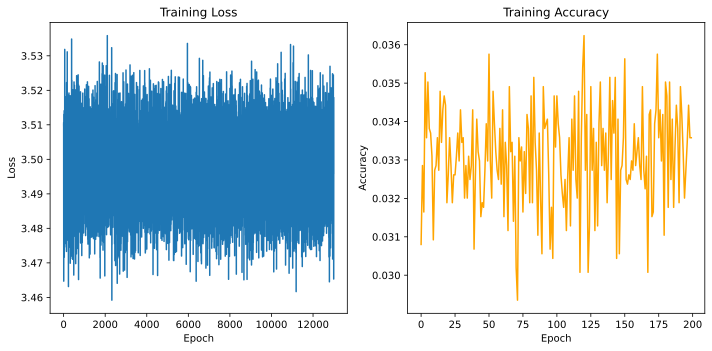

In [217]:
# 绘制损失曲线和准确率变化曲线
plt.figure(figsize=(10, 5))  # 设置整体图的大小

# 创建第一个子图（左侧），绘制训练损失曲线
plt.subplot(1, 2, 1)  # 参数依次为：行数，列数，子图编号
plt.plot(range(len(losses_1)), losses_1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# 创建第二个子图（右侧），绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies_1)), accuracies_1, color='orange')  # 使用橙色表示准确率
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout() # 调整子图的布局，防止重叠

In [173]:
# 测试网络
correct = 0
total = 0
all_preds_1 = []
all_labels_1 = []
# model.eval()
with torch.no_grad():
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)  # 将数据移动到GPU
        Pred = model_1(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds_1.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels_1.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total += y.size(0)
accuracy_1 = correct/total

# 随机网格搜索评价指标
accuracy_score_1 = accuracy_1
kappa_score_1 = cohen_kappa_score(all_labels_1, all_preds_1)
cm_1 = confusion_matrix(all_labels_1, all_preds_1)

In [125]:
# 贝叶斯优化最佳参数
model_2 = DNN(input_size, num_classes, [124,61,253], 0.28)
model_2.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00143392)
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量)
EPOCHS = 500

losses_2 = []
model.train()
for epoch in range(EPOCHS):
        for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model_2(x) # 一次前向传播（小批量）
            _, Pred_classes = torch.max(Pred, dim=1)
            total_correct += torch.sum(Pred_classes == y)
            total_samples += y.size(0)
            loss = loss_fn(output, y) # 计算损失函数
            losses_2.append(loss.item()) # 记录损失函数的变化
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
        accuracy = total_correct / total_samples
        accuracies.append(accuracy.item())

correct = 0
total = 0
all_preds_2 = []
all_labels_2 = []
model.eval()
with torch.no_grad():
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)  # 将数据移动到GPU
        Pred = model_2(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds_2.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels_2.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total += y.size(0)
accuracy_2 = correct/total

# 贝叶斯优化评价指标
accuracy_score_2 = accuracy_2
kappa_score_2 = cohen_kappa_score(all_labels_2, all_preds_2)
cm_2 = confusion_matrix(all_labels_2, all_preds_2)

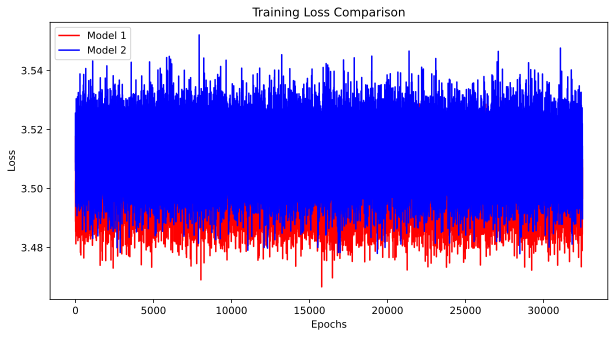

In [126]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))  # 设置图的大小

# 绘制第一个损失曲线
plt.plot(range(len(losses_1)), losses_1, label='Model 1',color='red')

# 绘制第二个损失曲线
plt.plot(range(len(losses_2)), losses_2, label='Model 2',color='blue')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()  # 显示图例，以区分不同模型的曲线

save_path = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标/loss_comparison.png'
plt.savefig('STD+DNN_loss_comparison.png')  # 保存图像

In [ ]:
# 绘制损失曲线，并保存

plt.plot(range(len(losses_1)), losses_1)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.plot(range(len(losses_2)), losses_2)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Training Loss')

In [127]:
# 打印，查看结果

accuracy_random = "{:.4f}".format(accuracy_score_1)
kappa_random = "{:.4f}".format(kappa_score_1)
opt_time_random = "{:.2f}".format(time_random)

accuracy_bayes = "{:.4f}".format(accuracy_score_2)
kappa_bayes = "{:.4f}".format(kappa_score_2)
opt_time_bayes = "{:.2f}".format(time_bayes)

print("\n","Accuracy_random:{}".format(accuracy_random)
    ,"\n","Kappa_random:{}".format(kappa_random)
    ,"\n","optimize_time_random:{}".format(opt_time_random))
print()
print("\n","Accuracy_bayes:{}".format(accuracy_bayes)
    ,"\n","Kappa_bayes:{}".format(kappa_bayes)
    ,"\n","optimize_time_bayes:{}".format(opt_time_bayes))


 Accuracy_random:0.0279 
 Kappa_random:-0.0009 
 optimize_time_random:25.38


 Accuracy_bayes:0.0248 
 Kappa_bayes:-0.0021 
 optimize_time_bayes:22.29


In [ ]:
# 保存 Accuracy，Kappa系数，优化时间
data = {
    'Random': [accuracy_random, kappa_random, opt_time_random],
    'Bayes': [accuracy_bayes, kappa_bayes, opt_time_bayes]
}

index = ['Accuracy', 'Kappa', 'Opt_time']
columns = ['Random', 'Bayes']

df = pd.DataFrame(data, index=index, columns=columns)
output_folder = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标'
csv_filename = 'SG+STD_PCA_DNN(Mini-batch).txt'
df.to_csv(f'{output_folder}/{csv_filename}', sep='\t', index=True)

In [ ]:
# 保存混淆矩阵
output_folder = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标'

csv_filename_1 = 'cm_SG+STD_PCA_DNN(Mini-batch)_Random.csv'
np.savetxt(f'{output_folder}/{csv_filename_1}', cm_1, delimiter=',', fmt='%d')

csv_filename_2 = 'cm_SG+STD_PCA_DNN(Mini-batch)_Bayes.csv'
np.savetxt(f'{output_folder}/{csv_filename_2}', cm_2, delimiter=',', fmt='%d')